Two-orbital model with Kanamori Interaction
=======

We calculate the Green function for a two-ortibal model with Kanamori Interaction

The local hamiltonian on the impurity site reads

$$h_{\rm loc} = h_0 + h_{\rm int}$$

where

$$h_0 = -\mu \, (n_{\uparrow, 0} + n_{\uparrow, 0} + n_{\uparrow, 1} + n_{\uparrow, 1})$$

$$h_{\rm int} = \frac{1}{2} \sum_{(i \sigma) \neq (j \sigma')} U_{i j}^{\sigma \sigma'} n_{i \sigma} n_{j \sigma'}
            - \sum_{i \neq j} J a^\dagger_{i \uparrow} a_{i \downarrow} a^\dagger_{j \downarrow} a_{j \uparrow}
            + \sum_{i \neq j} J a^\dagger_{i \uparrow} a^\dagger_{i \downarrow} a_{j \downarrow} a_{j \uparrow} $$

The bath is defined via the hybridization function

$$\Delta^{\sigma}_{i,j}(i\omega) = V^2 \delta_{i,j} \left(\frac{1}{i\omega - \epsilon} + \frac{1}{i\omega + \epsilon}\right)$$
The parameters are defined below.

In [ ]:
# %load system.py
execfile('../common/util.py')

from pytriqs.gf import Gf, MeshImFreq, iOmega_n, inverse
from pytriqs.operators import c, c_dag, n
from pytriqs.operators.util.hamiltonians import h_int_kanamori
from itertools import product
import numpy as np

# ==== System Parameters ====
beta = 5.           # Inverse temperature
mu = 2.             # Chemical potential
U = 5.              # On-site density-density interaction
J = 0.2             # Hunds coupling
V = 1.0             # Bath coupling
epsilon = 2.3       # Bath state energy

# ==== Local Hamiltonian ====
J = 0.

h_0 = - mu*( n('up',0) + n('dn',0) + n('up',1) + n('dn',1) )
h_int = h_int_kanamori(['up','dn'],[0,1],
                        # np.array([[0,U-3*J],[U-3*J,0]]),
                        np.array([[0,0],[0,0]]),
                        # np.array([[U,U-2*J],[U-2*J,U]]),
                        np.array([[U,0],[0,U]]),
                        J,True)
h_loc = h_0 + h_int

# ==== Green function structure ====
gf_struct = [ ['up',[0,1]], ['dn',[0,1]] ]

# ==== Hybridization Function ====
n_iw = 20
iw_mesh = MeshImFreq(beta, 'Fermion', n_iw)
Delta = Gf_from_struct(mesh=iw_mesh, struct=gf_struct)
Delta << (V**2) * inverse(iOmega_n - epsilon) + (V**2) * inverse(iOmega_n + epsilon);

# ==== Non-Interacting Impurity Green function  ====
G0_iw = Gf_from_struct(mesh=iw_mesh, struct=gf_struct)
G0_iw['up'] << 1.0 * inverse(iOmega_n + mu - Delta['up']) # FIXME Should work for BlockGf
G0_iw['dn'] << 1.0 * inverse(iOmega_n + mu - Delta['dn'])


Results
====

In [2]:
from pytriqs.plot.mpl_interface import oplot, plt
%matplotlib inline

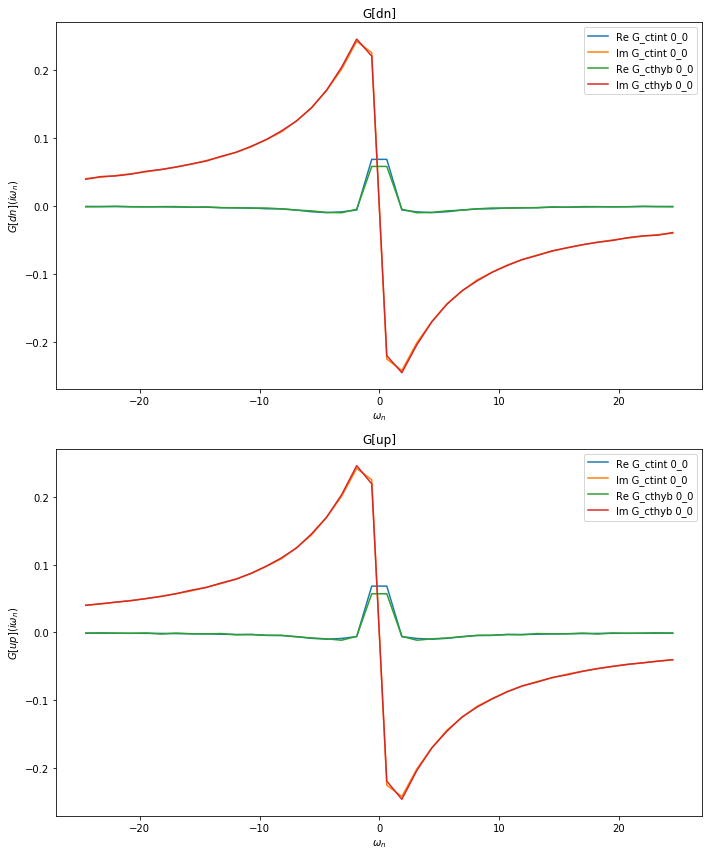

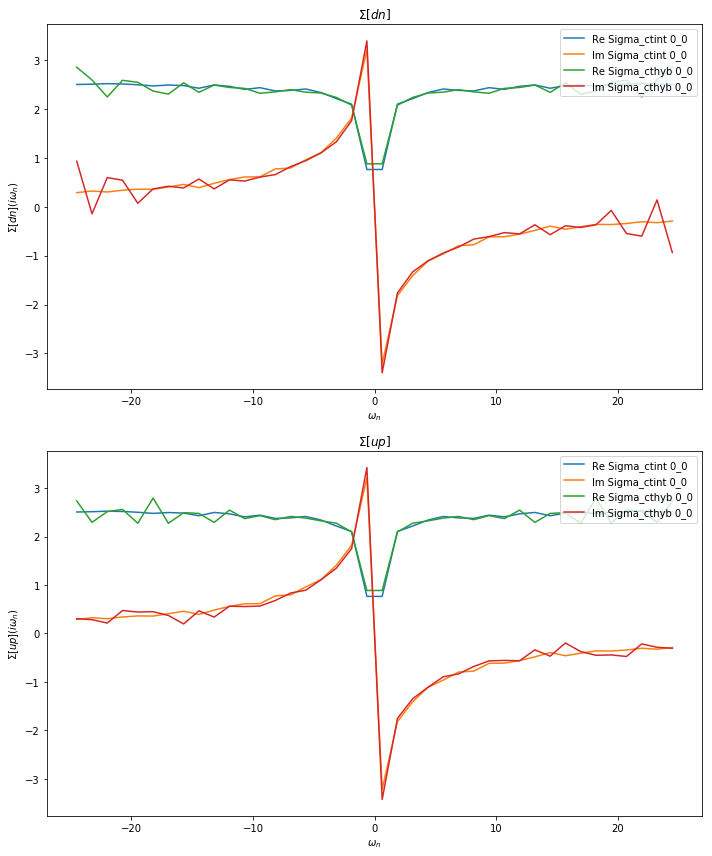

In [7]:
# %load common/plot.py
from pytriqs.archive import HDFArchive
from pytriqs.gf import Gf
from pytriqs.plot.mpl_interface import oplot, plt
from glob import glob
from os.path import basename

# === Load Green function for every solver

file_lst = glob('results/*.h5')
solver_lst, G = [], {}

for f in file_lst:
    solver = basename(f).strip('.h5')
    solver_lst.append(solver)
    G[solver] = HDFArchive(f,'r')['G']

# === For every block, plot Green functions of all solvers

block_lst = list(G[solver_lst[0]].indices)
n_blocks = len(block_lst)

plt.subplots(n_blocks,1,figsize=(10,6*n_blocks))

for i, block in enumerate(block_lst,1):
    fig = plt.subplot(n_blocks,1,i)
    fig.set_title("G[" + block + "]")
    for solver in solver_lst:
        oplot(G[solver][block][0,0], name = "G_%s" % solver)
    plt.xlabel("$\omega_n$")
    plt.ylabel("$G[" + block + "](i\omega_n)$")

plt.tight_layout()
plt.show()

plt.subplots(n_blocks,1,figsize=(10,6*n_blocks))

# Sigma
for i, block in enumerate(block_lst,1):
    fig = plt.subplot(n_blocks,1,i)
    fig.set_title("$\Sigma[" + block + "]$")
    Sigma = G0_iw[block].copy()
    for solver in solver_lst:
        Sigma << inverse(G0_iw[block]) - inverse(G[solver][block])
        oplot(Sigma[0,0], name = "Sigma_%s" % solver)
    plt.xlabel("$\omega_n$")
    plt.ylabel("$\Sigma[" + block + "](i\omega_n)$")
    
plt.tight_layout()
plt.show()

Deviations
======

We present a table containing deviations between the different solvers measured via

$$||G_{\rm Solver_1} - G_{\rm Solver_2}||_\infty$$

In [4]:
import numpy as np

for block in block_lst:
    deviations = [[ np.amax(np.abs(G[s1][block].data - G[s2][block].data)) for s1 in solver_lst ] \
                    for s2 in solver_lst ]
    
    print "\t\t    Deviations for Block " + block
    print "\t\t -----------------------------------"

    row_format ="{:>15}" * (len(solver_lst) + 1)
    print row_format.format("", *solver_lst)
    row_format ="{:>15}" + "{:>15.2E}" * len(solver_lst)
    for solver, row in zip(solver_lst, deviations):
        print row_format.format(solver, *row)
        
    print "\n\n"

		    Deviations for Block dn
		 -----------------------------------
                         ctint          cthyb
          ctint       0.00E+00       1.16E-02
          cthyb       1.16E-02       0.00E+00



		    Deviations for Block up
		 -----------------------------------
                         ctint          cthyb
          ctint       0.00E+00       1.28E-02
          cthyb       1.28E-02       0.00E+00



